In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import suppression as s
import utils
import two_stage_model as model
import linear_model as lm

In [5]:
gaba_fn = 'gaba_data.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [6]:
sdf = utils.load_psychophys(supp_fn)
gdf = utils.load_gaba(gaba_fn)

## Analyze tasks separately (before subsetting to include common subjects)##

In [7]:
pp_subjs = np.unique(sdf.Subject)
gaba_subjs = np.unique(gdf.subjName)
print(pp_subjs, len(pp_subjs))
print(gaba_subjs, len(gaba_subjs))

['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em' 'es'
 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv' 'nl' 'nn'
 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl'] 37
['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm'
 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn' 'sd' 'tt'
 'yl'] 31


### GABA plot, n=31 (all)

### GABA t-test, CON v AMB

In [8]:
pop_group = gdf.groupby("Population")
pop_group.describe()

GABA                                                           
           count      mean       std    min     25%     50%      75%    max
Population                                                                 
Amblyope    16.0  0.202312  0.013385  0.179  0.1925  0.2025  0.21125  0.227
Control     15.0  0.206333  0.016482  0.173  0.1925  0.2110  0.21650  0.228

In [9]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group)
print(tstat, pval)

-0.747810754413 0.460595837907


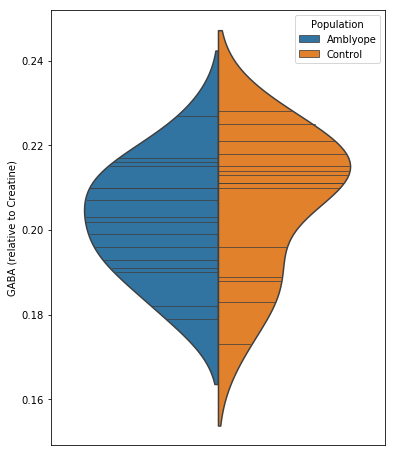

In [10]:
with s.PdfPages('plots/redo-201805/gaba_diffs_n31.pdf') as pdf:
    fig = plt.figure(figsize=(6,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gdf,split=True,inner='stick',ax=ax)
    ax.xaxis.set_visible(False)
    ax.set_ylabel("GABA (relative to Creatine)")
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

## Select one psychophysical task's data ##

In [11]:
task = 'SS'
sdf = sdf[sdf['Task']==task]

### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [12]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

In [13]:
# create groups based on these grouping variables
groups = sdf.groupby(pp_gvars)
print(len(groups))
#for gv, g in groups:
#    print(gv)

256


### Do t-tests between corresponding points (to find bin where the groups are most different)

In [14]:
tt_df = sdf

In [15]:
tt_df.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811


In [16]:
gvars_ttest = ['Task','Orientation','Presentation','Population']
gvars_pair = gvars_ttest + ['BinNumber']

tt_grouped = tt_df.groupby(gvars_ttest)
print(len(tt_grouped))

for gv, g in tt_grouped:
    print(gv)

8
('SS', 'Cross', 'nDicho', 'Amblyope')
('SS', 'Cross', 'nDicho', 'Control')
('SS', 'Cross', 'nMono', 'Amblyope')
('SS', 'Cross', 'nMono', 'Control')
('SS', 'Iso', 'nDicho', 'Amblyope')
('SS', 'Iso', 'nDicho', 'Control')
('SS', 'Iso', 'nMono', 'Amblyope')
('SS', 'Iso', 'nMono', 'Control')


In [17]:
def tt(ttg_allbin):
    '''Accepts data grouped by Task, Orientation, Presentation, Population, then analyzes each bin within this.'''
    g_bin = ttg_allbin.groupby(gvars_pair).apply(tt_onebin).reset_index()
    minp_bin = g_bin.BinNumber.iat[g_bin.pvalue.idxmin()]
    print('Bin ', minp_bin, 'has lowest p-value.\n')
    return pd.Series(minp_bin, ['BinNumberToPred'])

def tt_onebin(ttg):
    '''Accepts data grouped by Task, Orientation, Presentation, Population, BinNumber, and does a t-test on the values in the bin.'''
    nde = ttg[ttg['Eye']=='Nde']['ThreshElev'].values
    de = ttg[ttg['Eye']=='De']['ThreshElev'].values
    print(ttg.name, ttg.BinCenterRelMaskContrast.iat[0], nde, de, sep='\n')
    if (len(nde) >0 and len(de) >0):
        tt_res = st.ttest_ind(nde, de)
        if tt_res:
            return pd.Series(tt_res[1], ['pvalue'])
    else:
        print('A group with no obs, skipping')

tt_results = tt_grouped.apply(tt).reset_index()

('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.921  1.434  0.805  1.043]
[ 0.947  1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.921  1.434  0.805  1.043]
[ 0.947  1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 2)
1.432
[ 1.23   1.056  1.057  2.058  1.112  1.755  0.888  1.296  1.229  1.076]
[ 0.859  0.542  0.98   0.642]
('SS', 'Cross', 'nDicho', 'Amblyope', 3)
2.604
[ 1.629  1.378  2.68   0.989  3.318  1.007  1.459  0.68   1.555  1.14 ]
[ 0.505  1.014  1.093  0.759  0.964  0.867  1.099  1.177  0.718]
('SS', 'Cross', 'nDicho', 'Amblyope', 4)
4.526
[ 1.783  1.275  1.585  4.893  1.056  1.195  1.369  1.222  1.337]
[ 0.689  0.553  0.935  0.99   1.22   0.617  1.125  1.17   0.76   0.591
  0.685]
('SS', 'Cross', 'nDicho', 'Amblyope', 5)
7.257
[ 1.81   1.677  2.306  1.377  1.49   2.387  0.82   1.708]
[ 0.792  0.416  0.918  0.855  0.956  1.     1.05   1.022  1.241]
('SS', 'Cross', 'nDicho', 'Amblyope', 6)
10.949
[ 1.79   1.331  1.419  1.277  4.002  1.711]
[ 0.898  0.48

In [18]:
tt_results

,Task,Orientation,Presentation,Population,BinNumberToPred
0,SS,Cross,nDicho,Amblyope,5
1,SS,Cross,nDicho,Control,1
2,SS,Cross,nMono,Amblyope,3
3,SS,Cross,nMono,Control,1
4,SS,Iso,nDicho,Amblyope,4
5,SS,Iso,nDicho,Control,6
6,SS,Iso,nMono,Amblyope,2
7,SS,Iso,nMono,Control,2


In [19]:
sdf = pd.merge(sdf, tt_results, on=gvars_ttest)

In [20]:
sdf.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,BinNumberToPred
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,2
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,2
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,2
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,2
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,2


In [21]:
# make sure all conditions have the same bin number to predict within them
condition_groups = sdf.groupby(gvars_ttest + ['Eye'])
assert(np.all(condition_groups.apply(
        lambda g: np.all(g.BinNumberToPred==g.BinNumberToPred.iat[0])
    ).reset_index()))

In [22]:
gvars_ttest

['Task', 'Orientation', 'Presentation', 'Population']

In [23]:
# add col with numeric value at which we want model to be evaluated
# this is determined per condition so reuse var
def add_pred_col(g):
    assert(np.all(g.BinNumberToPred==g.BinNumberToPred.iat[0]))
    RelMCToPredGroup = g[g.BinNumber==g.BinNumberToPred.iat[0]]
    assert(np.all(RelMCToPredGroup.BinCenterRelMaskContrast==RelMCToPredGroup.BinCenterRelMaskContrast.iat[0]))
    RelMCToPred = RelMCToPredGroup.BinCenterRelMaskContrast.iat[0]
    print(RelMCToPred, len(g))
    g['RelMCToPred'] = RelMCToPred
    return g
    
df_to_model = condition_groups.apply(add_pred_col)

4.33 51
4.33 51
7.257 49
0.879 54
0.991 84
2.637 53
1.496 52
0.971 54
0.925 88
2.5 51
4.526 49
11.877 54
11.35 85
1.463 53
0.878 54
1.599 54
1.552 85


In [24]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,BinNumberToPred,RelMCToPred
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,2,1.552
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,2,1.552
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,2,1.552
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,2,1.552
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,2,1.552


In [25]:
n_pp_subs_thistask = len(np.unique(df_to_model.Subject))
print(n_pp_subs_thistask, len(np.unique((df_to_model[df_to_model['Population']=='Amblyope'])['Subject'])))

35 13


### Linear model (defined in linear_model.py, uses lmfit)###

In [ ]:
# initialize parameters
lm_params = lm.linear_model_parameters()

### Two-stage Model (defined in two_Stage_model.py)

In [26]:
twostage_params = model.two_stage_parameters()

### Model all data points, incl. facilitation ###

In [27]:
groups = df_to_model.groupby(pp_gvars)

In [28]:
# two-stage model
preds_wfac = groups.apply(s.model_condition, model.two_stage_response_err, model.two_stage_thresh, twostage_params,
                     ret='preds', supp_only=False, log=False)

('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De') 4.33
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       2.627     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d   0.04319        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De') 4.33
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf       

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       5.795     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d   0.02761        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'em', 'Nde', 'Amblyope-Nde') 7.257
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.9752     -inf      inf      

q         6.5     -inf      inf        0    False     None     None
w_d   0.01588        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'sd', 'Nde', 'Amblyope-Nde') 7.257
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       15.95     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.5205        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'ai

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a      0.3799     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.446        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'gm', 'De', 'Control-De') 0.879
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       41.09     -inf      inf        0 

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a      0.4336     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d  0.0006334        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'nl', 'De', 'Control-De') 0.879
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.2421     -inf      inf        0

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        2766     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.1464        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde') 1.496
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a      0.6809     -inf      inf       

('SS', 'Cross', 'nMono', 'Amblyope', 'jv', 'De', 'Amblyope-De') 2.637
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.2829     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  2.798e-14        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'jv', 'Nde', 'Amblyope-Nde') 1.496
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf    

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4535     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  5.639e-10        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'ai', 'De', 'Control-De') 0.971
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        8095     -inf      inf        0 

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       4.387     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.1767        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'es', 'Nde', 'Control-Nde') 0.925
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a      0.8197     -inf      inf        0

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       25.76     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m   0.08728        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'ms', 'Nde', 'Control-Nde') 0.925
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       1.169     -inf      inf        0

w_d    0.8196        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De') 2.5
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       822.7     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.1287        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde') 4.526
Name     Value      Min      Max   Stderr  

p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d   0.00514        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Amblyope', 'li', 'De', 'Amblyope-De') 2.5
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.3527     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d  2.661e-09        0      inf        0     True     None     None
w_m         1        0      inf        0     

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4069     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     0.992        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'cr', 'De', 'Control-De') 11.877
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.3482     -inf      inf        0  

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    1.286e+04     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.814        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'jd', 'De', 'Control-De') 11.877
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.3355     -inf      inf        0 

Z      0.0085     -inf      inf        0    False     None     None
a       97.81     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.5583        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'se', 'Nde', 'Control-Nde') 11.35
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       64.86     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.5833     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  1.719e-10        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Amblyope', 'eg', 'De', 'Amblyope-De') 1.463
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.3997     -inf      inf        0 

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    4.029e+04     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     1.854        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Amblyope', 'mg', 'Nde', 'Amblyope-Nde') 0.878
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        1972     -inf      inf        

('SS', 'Iso', 'nMono', 'Control', 'ct', 'De', 'Control-De') 1.599
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    3.059e+12     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     23.82        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'ct', 'Nde', 'Control-Nde') 1.552
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0   

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4324     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  1.068e-11        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'ke', 'Nde', 'Control-Nde') 1.552
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    3.247e+36     -inf      inf        0

p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     2.189        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'se', 'De', 'Control-De') 1.599
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        5403     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     1.544        0      inf        0     Tr

In [ ]:
# linear model
preds_wfac = groups.apply(s.model_condition, s.linear_nofac_err, s.linear_nofac_thresh, lm_params,
                     ret='preds', supp_only=False, log=False)

## Descriptive statistics

In [29]:
preds_wfac.groupby(["Orientation", "Presentation", "Population", "Eye"])["ThreshPred"].describe()

count      mean       std       min  \
Orientation Presentation Population Eye                                        
Cross       nDicho       Amblyope   De    51.0  0.975217  0.264189  0.534421   
                                    Nde   49.0  1.627116  0.801167  0.678062   
                         Control    De    54.0  1.264302  0.468741  0.657501   
                                    Nde   84.0  1.564769  0.882741  0.736005   
            nMono        Amblyope   De    53.0  1.010786  0.356519  0.375205   
                                    Nde   52.0  1.140856  0.288618  0.634256   
                         Control    De    54.0  0.960596  0.270584  0.443248   
                                    Nde   88.0  1.074741  0.300286  0.491430   
Iso         nDicho       Amblyope   De    51.0  1.042895  0.343703  0.427404   
                                    Nde   49.0  2.396705  1.463358  0.819520   
                         Control    De    54.0  1.960642  1.064641  0.757943   
                                    Nde   85.0  2.370134  1.455236  0.669476   
            nMono        Amblyope   De    53.0  1.490869  0.918131  0.460578   
                                    Nde   54.0  1.676980  1.051060  0.549100   
                         Control    De    54.0  1.597933  1.057483  0.571856   
                                    Nde   85.0  1.788822  1.307768  0.534827   

                                              25%       50%       75%  \
Orientation Presentation Population Eye                                 
Cross       nDicho       Amblyope   De   0.782305  0.980038  1.107774   
                                    Nde  1.154316  1.379361  1.705411   
                         Control    De   0.979157  1.155054  1.396192   
                                    Nde  1.071704  1.274188  1.808404   
            nMono        Amblyope   De   0.807413  0.992321  1.208030   
                                    Nde  0.956699  1.089090  1.237885   
                         Control    De   0.745979  0.920035  1.088089   
                                    Nde  0.884248  1.013776  1.241043   
Iso         nDicho       Amblyope   De   0.792494  1.074041  1.233446   
                                    Nde  1.311639  1.794498  3.032507   
                         Control    De   1.228429  1.606102  2.452052   
                                    Nde  1.304486  1.939783  3.177565   
            nMono        Amblyope   De   0.876058  1.178174  1.804663   
                                    Nde  1.071177  1.361472  1.898294   
                         Control    De   0.834700  1.337243  1.860118   
                                    Nde  1.047612  1.379156  2.116029   

                                              max  
Orientation Presentation Population Eye            
Cross       nDicho       Amblyope   De   1.699584  
                                    Nde  4.777451  
                         Control    De   2.868397  
                                    Nde  5.931214  
            nMono        Amblyope   De   1.947753  
                                    Nde  2.100402  
                         Control    De   1.812795  
                                    Nde  2.002172  
Iso         nDicho       Amblyope   De   2.258548  
                                    Nde  6.434978  
                         Control    De   5.648059  
                                    Nde  7.911608  
            nMono        Amblyope   De   5.231409  
                                    Nde  5.751733  
                         Control    De   6.344531  
                                    Nde  9.224384

In [30]:
s.group_facet_plots(preds_wfac, s.fit_plot, 'plots/redo-201805/{}_regressions_combinedplots_n{}.pdf'.format(task, n_pp_subs_thistask),
                  ['Task','Orientation','Presentation'], #each combo of this gets its own page
                  row='Population',col='Eye',# facet rows and columns
                  x="RelMaskContrast", y="ThreshElev", # x, y
                  hue="Subject",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshPred") 

Plotting SS.Cross.nDicho
Plotting SS.Cross.nMono
Plotting SS.Iso.nDicho
Plotting SS.Iso.nMono
Plots saved at plots/redo-201805/SS_regressions_combinedplots_n35.pdf


### Model the data again, but this time return parameters, not predictions ###

In [32]:
print(pp_gvars_base)
groups_with_baseline = df_to_model.groupby(pp_gvars_base)

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [33]:
# two-stage model
pfit = groups_with_baseline.apply(s.model_condition, model.two_stage_response_err, model.two_stage_thresh,
                                  twostage_params, ret='weights',
                                  supp_only=False).reset_index()

('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De', 7.5899999999999999) 4.33
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       2.627     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d   0.04319        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De', 7.5899999999999999) 4.33
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     Non

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        20.1     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.4264        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'jv', 'De', 'Amblyope-De', 4.2270000000000003) 4.33
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.3038     -i

m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d   0.01588        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'sd', 'Nde', 'Amblyope-Nde', 13.225999999999999) 7.257
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       15.95     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.5205       

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       41.09     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.4485        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'gm', 'Nde', 'Control-Nde', 6.4050000000000002) 0.991
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       3.024     -

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.2421     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d  3.353e-11        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'nl', 'Nde', 'Control-Nde', 5.2759999999999998) 0.991
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       17.28     

w_m    0.2041        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'am', 'De', 'Amblyope-De', 7.532) 2.637
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        2766     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.1464        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde', 7.8339999999999996) 1.496
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S        

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.2829     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  2.798e-14        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'jv', 'Nde', 'Amblyope-Nde', 4.7639999999999993) 1.496
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    1.425e+36   

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4535     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  5.639e-10        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'ai', 'De', 'Control-De', 6.9429999999999996) 0.971
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        8095     -in

q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m   0.04463        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'es', 'De', 'Control-De', 5.4779999999999998) 0.971
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       4.387     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.1767        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 

p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     0.249        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'mk', 'Nde', 'Control-Nde', 6.6110000000000007) 0.925
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        26.3     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m   0.09684        0 

m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.1954        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'yl', 'De', 'Control-De', 5.2720000000000002) 0.971
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       2.061     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0   

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       2.114     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.427        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Amblyope', 'gd', 'De', 'Amblyope-De', 6.21) 2.5
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a      -0.296     -inf      inf      

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       69.51     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.002        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'ai', 'Nde', 'Control-Nde', 6.9000000000000004) 11.35
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4837     -in

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.5376     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.302        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'gm', 'De', 'Control-De', 6.6299999999999999) 11.877
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4096     -inf

('SS', 'Iso', 'nDicho', 'Control', 'ms', 'De', 'Control-De', 4.609) 11.877
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       16.26     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.5184        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'ms', 'Nde', 'Control-Nde', 4.2139999999999995) 11.35
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085 

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        9581     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     1.357        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Amblyope', 'ah', 'Nde', 'Amblyope-Nde', 4.5579999999999998) 0.878
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.3353     -i

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       246.1     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     1.325        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Amblyope', 'gd', 'Nde', 'Amblyope-Nde', 6.5360000000000005) 0.878
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       7.792     -i

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        1803     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.9697        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Amblyope', 'sd', 'Nde', 'Amblyope-Nde', 13.225999999999999) 0.878
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.5394     -i

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    1.17e+06     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     3.433        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'ei', 'Nde', 'Control-Nde', 4.9850000000000003) 1.552
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4177     -inf

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    8.36e+10     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     14.48        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'mk', 'Nde', 'Control-Nde', 6.6110000000000007) 1.552
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    3.832e+05     -in

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    8.184e+40     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  2.822e+04        0      inf        0     True     None     None


In [ ]:
# linear model
# pfit = groups_with_baseline.apply(s.model_condition, s.linear_nofac_err, s.linear_nofac_thresh,
#                                   lm_params, ret='weights', predtype='linear', 
#                                   supp_only=False).reset_index()

In [34]:
pfit.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,m,S,w_m,w_d,a,k,p,q,Z
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,1.3,1.0,1.0,0.043186,2.626651,0.2,8.0,6.5,0.0085
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.3,1.0,1.0,0.132988,-0.417262,0.2,8.0,6.5,0.0085
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,7.532,1.3,1.0,1.0,0.053725,74.492189,0.2,8.0,6.5,0.0085
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,1.3,1.0,1.0,0.020711,-0.379194,0.2,8.0,6.5,0.0085
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,1.3,1.0,1.0,0.060870,1.429725,0.2,8.0,6.5,0.0085


In [35]:
# melt the result of the modeling into long format for plotting
pfit_all_ppsub = pd.melt(pfit, id_vars=pp_gvars, var_name='measure')
pfit_all_ppsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.590
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,BaselineThresh,4.558
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,BaselineThresh,7.532
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,7.834
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,7.827


In [36]:
len(np.unique(pfit_all_ppsub.Subject))

35

In [38]:
pfit_all_ppsub[pfit_all_ppsub.measure=="w_d"].describe()

,value
count,2.560000e+02
mean,1.197830e+01
std,1.711209e+02
min,1.389999e-13
25%,1.254900e-01
50%,1.000000e+00
75%,1.000000e+00
max,2.734947e+03


# Test next part carefully, copy/paste

## subset to include common subjects

In [39]:
use_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
print(use_subjs, len(use_subjs))

['ai', 'am', 'bi', 'cr', 'ct', 'dl', 'ei', 'em', 'es', 'gd', 'gm', 'jd', 'jv', 'kw', 'li', 'ls', 'mg', 'mk', 'ms', 'nl', 'rn', 'sd', 'tt', 'yl'] 24


In [40]:
sdf = sdf[sdf.Subject.isin(use_subjs)] # only subjects who did _the current_ pp task and GABA
len(np.unique(sdf.Subject))
# make sure there are only as many unique subjNames in sdf as there are entries in gdf.subjName
#assert(len(np.unique(sdf.Subject))==len(gdf.subjName))

23

In [41]:
len(gdf[gdf['Population']=='Amblyope'])

16

In [42]:
print(len(gdf), len(gdf[gdf.Population=='Amblyope']))

31 16


In [43]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
print(len(gdf), len(gdf[gdf.Population=='Amblyope']))
n_this_task = len(gdf)

23 9


## Combine Psychophysics and GABA below

In [ ]:
#Grab the GABA measure for each subject and it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
print(len(comb))

#subset to include only two measures of interest: normalized thresh elev, and unnormed
comb_all_ppsub = comb[(comb['measure']=='ThreshPredCritical') | (comb['measure'] == 'ThreshPredCriticalUnnorm') | (comb['measure'] == 'BaselineThresh')]
print(len(comb_all_ppsub))

#subset to include only those subjects with GABA data
comb_gabappsub = comb_all_ppsub[~np.isnan(comb_all_ppsub['GABA'])]
print(len(comb_gabappsub), len(np.unique(comb_gabappsub.Subject)))

In [ ]:
#graphs!
with s.PdfPages('plots/collab-201710/gaba_vs_{}_n{}.pdf'.format(task, n_this_task)) as pdf:
    plot_groups = comb_gabappsub.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv, np.all(np.isnan(gr['value'])))
        #print(gr.columns)
        #if gv[0]=='SS' and gv[1]=='Cross': continue
        g2 = s.gaba_vs_psychophys_plot_2line(gv, gr)
        pdf.savefig(g2.fig)
        #g4 = s.gaba_vs_psychophys_plot_4line(gv, gr)
        #pdf.savefig(g4.fig)
        
    plt.close('all')

#### combine measures across the two eyes

In [ ]:
paired_obs = comb_gabappsub.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2:
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        #print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])

In [ ]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

In [ ]:
obs_diff.head(n=6)

In [ ]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [ ]:
comb_botheyes.head()

In [ ]:
to_write = comb_botheyes[(comb_botheyes.Presentation == 'nDicho') & (comb_botheyes.measure == 'ThreshPredCriticalUnnorm')]

In [ ]:
to_write.to_csv('gaba_vs_ss_dicho.csv')

In [ ]:
print(len(np.unique(comb_botheyes.Subject)))

In [ ]:
#graphs!
with s.PdfPages('plots/collab-201710/gaba_vs_{}_combeyes_n{}.pdf'.format(task, n_this_task)) as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr)
        pdf.savefig(g2.fig)
        
    plt.close('all')

In [ ]:
# more graphs for presentation!
with s.PdfPages('plots/collab-201710/gaba_vs_{}_combeyes_n{}_condensed.pdf'.format(task, n_this_task)) as pdf:
    plot_groups = comb_botheyes.groupby(['Task','measure'])
    for gv, gr in plot_groups:
        print(gv)
        if "BaselineThresh" not in gv:
            g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr, row="Orientation", size=8, aspect=1.2)
            pdf.savefig(g2.fig)
        
    plt.close('all')